## The transient Universe


### Tasks

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**


1) Read in `solutions/transient.npy`. This is a (10 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc3`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from tqdm import tqdm
import emcee
import corner

plt.rcParams['figure.figsize']=(7,5) 
plt.rcParams['font.size']=16 
plt.rcParams['font.family']='Liberation Serif' 
plt.rcParams['figure.autolayout']=True 
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
data = np.load('/home/irene/Downloads/transient.npy')

Text(0, 0.5, 'Flux')

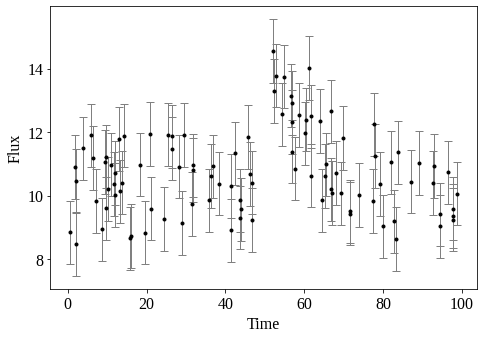

In [3]:
time = data[:, 0]
flux = data[:, 1]
err = data[:, 2]
t, y, yerr = data.T

plt.errorbar(time,flux,yerr=err,fmt='.k', ecolor='gray', lw=1,label='data', capsize = 4)
plt.xlabel("Time")
plt.ylabel("Flux")

In [4]:
#fit function
def exp_fit(x, par):
    A = par[0]
    b = par[1]
    alpha = par[2]
    t0 = par[3]
    return np.where(x < t0, b, b + A*np.exp(-alpha*(x - t0)))

#loglikelihood
def LogLike(data, par, model):
    y = model(data[:, 0], par)
    return -0.5*np.sum((data[:, 1]-y)**2/data[:, 2]**2 )

#logprior
t0min,t0max = 0,100
Amin,Amax = 0,50
bmin,bmax = 0,50
alphamin,alphamax = np.exp(-5),np.exp(5)

def Logprior(par):
    A = par[0]
    b = par[1]
    alpha = par[2]
    t0 = par[3]
    if Amin < A < Amax and bmin < b < bmax and t0min < t0 < t0max and alphamin < alpha < alphamax:
        return -np.log(alpha)
    else:
        return -np.inf

#logposterior
def Logposterior(par, data, model):
    return LogLike(data, par , model) + Logprior(par)

alpha_max =  0.0986265846131282


<ipython-input-4-53a1318f70bd>:7: RuntimeWarning: overflow encountered in multiply
  return np.where(x < t0, b, b + A*np.exp(-alpha*(x - t0)))
<ipython-input-4-53a1318f70bd>:7: RuntimeWarning: overflow encountered in exp
  return np.where(x < t0, b, b + A*np.exp(-alpha*(x - t0)))


Text(0, 0.5, 'log(conditional Likelihood)')

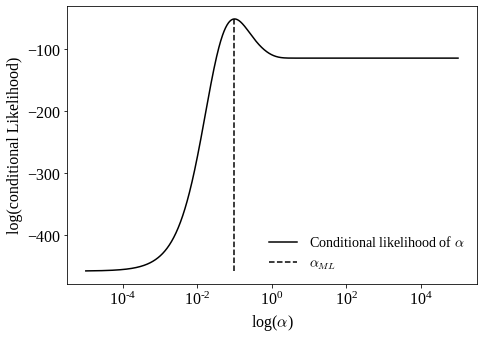

In [5]:
#I choose to initialize alpha at the value that maximizes the conditional likelihood, with all other parameters set
#at their true values evaluated by eye

alpha_test = np.logspace(-5,5, 1000)
like_alpha = []
for al in alpha_test:
    par = np.array([5, 10, al, 50])
    like_alpha.append(LogLike(data, par, exp_fit))

alpha_max = alpha_test[np.argmax(like_alpha)]
print('alpha_max = ', alpha_max)

#draw
plt.plot(alpha_test, like_alpha, color = 'black', label = r'Conditional likelihood of $\alpha$')
plt.vlines(x = alpha_max, ymin = min(like_alpha), ymax = max(like_alpha), color = 'black', linestyle='dashed', label = r'$\alpha_{ML}$')
plt.xscale('log')
plt.legend(frameon = False, fontsize = 14)
plt.xlabel(r'log($\alpha$)')
plt.ylabel('log(conditional Likelihood)')

In [6]:
ndim = 4  # number of parameters in the model
nwalkers = 20  # number of MCMC walkers
nsteps = 10000  # number of MCMC steps to take for each walker

#starting parameters
np.random.seed(0)
A_0 = 5 + 0.1*np.random.randn(nwalkers)
b_0 = 10 + 0.1*np.random.randn(nwalkers)
alpha_0 = alpha_max + 0.1*np.random.randn(nwalkers)
t0_0 = 50 + 1*np.random.randn(nwalkers)

par_0 = np.array([A_0, b_0, alpha_0, t0_0]).transpose()

In [7]:
chain = emcee.EnsembleSampler(nwalkers, ndim, Logposterior, args=[data, exp_fit]) #
chain.run_mcmc(par_0, nsteps);

/home/irene/.local/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Text(0.5, 0, 'Step number')

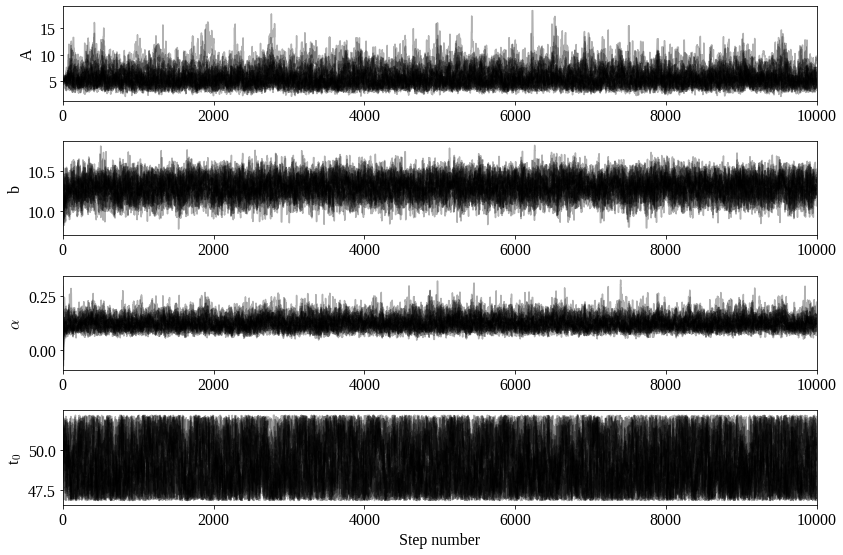

In [8]:
#get the samples
samples = chain.get_chain()

#plot the samples
labels=['A', 'b', r'$\alpha$', r't$_{0}$']
fig, ax = plt.subplots(ndim, figsize=(12, 8))
for i in range(ndim):
    ax[i].plot(samples[:, :, i], color='black', alpha=0.3)
    ax[i].set_xlim(0, nsteps)
    ax[i].set_ylabel(labels[i])
    
ax[3].set_xlabel("Step number")

In [9]:
#find the autocorrelation time to chose the burn-in and perform the thinning
tau = chain.get_autocorr_time()
print(samples.shape)
new_samples = chain.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)
np.array(new_samples.shape)

(10000, 20, 4)


array([2520,    4])

In [10]:
#print the parameters median and the 90% confidence level
median_parameters = []
low_err = []
up_err = []

for i in range(ndim):
    low, med, up = np.percentile(new_samples[:,i],[5,50, 95])
    median_parameters.append(med)
    low_err.append(med - low)
    up_err.append(up - med)
    print(labels[i], med, '+', up-med, '-', med-low)

A 5.4027591261122945 + 3.573999763138418 - 1.8441324727579778
b 10.296910317944665 + 0.2083235238138652 - 0.20635289506523513
$\alpha$ 0.1228149633436262 + 0.05304509640425402 - 0.03756799496313068
t$_{0}$ 49.0934199047595 + 2.762763375010209 - 2.0498433166650614


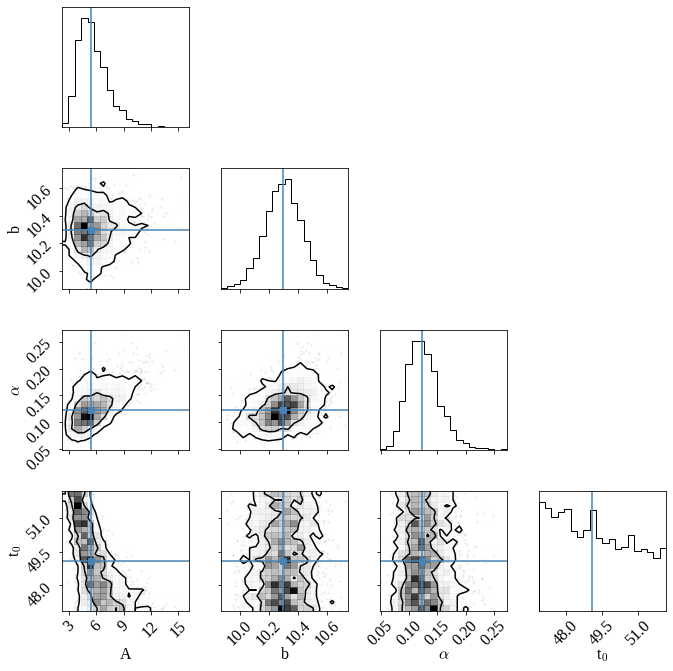

In [12]:
# Make the corner plot with posterior medians
figure = corner.corner(new_samples, truths = median_parameters, truths_color = 'tab:red', labels=labels, levels=[0.683,0.955]);

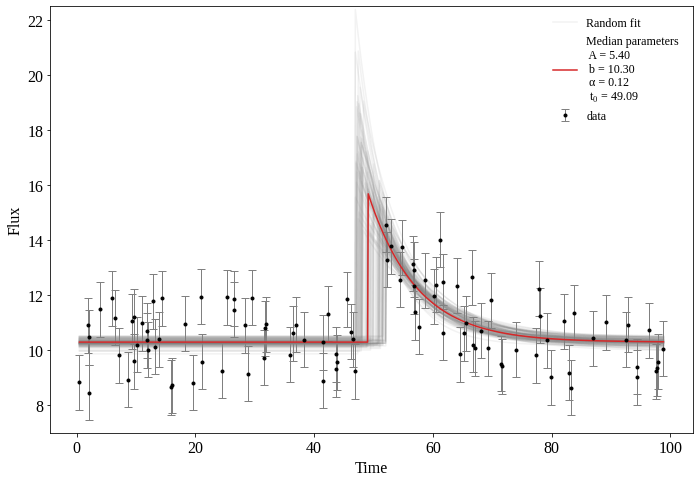

In [13]:
#draw 100 fits
plt.rcParams['figure.figsize']=(10,7) 

plt.errorbar(time,flux,yerr=err,fmt='.k', ecolor='gray', lw=1,label='data', capsize = 4)
plt.xlabel("Time")
plt.ylabel("Flux")

np.random.seed(42)
t = np.linspace(min(time), max(time), 1000)
for i in range(100):
    j = np.random.randint(0, 1e3, 1)
    if i == 0:
        plt.plot(t, exp_fit(t, new_samples[j][0]), color='grey', alpha=0.1, label = 'Random fit')
    else:
        plt.plot(t, exp_fit(t, new_samples[j][0]), color='grey', alpha=0.1)

#plot the fit with the medians of the parameters 
plt.plot(t, exp_fit(t, median_parameters), color = 'tab:red', label = 'Median parameters \n A = {:1.2f}\n b = {:1.2f} \n α = {:1.2f} \n t$_0$ = {:1.2f}'.format(median_parameters[0], median_parameters[1], median_parameters[2], median_parameters[3]))

plt.legend(frameon=False, fontsize=12)
plt.ylim([7, 22.5])
plt.savefig('fit.pdf')

### Try also to fit the data with a Gaussian

In [14]:
#gaus_fit function
def gaus_fit(x, par):
    return par[1] + par[0]*np.exp(-(x - par[3])**2/(2*par[2]**2))

In [15]:
par_0 = np.array([A_0, b_0, alpha_0, t0_0]).transpose()

chain = emcee.EnsembleSampler(nwalkers, ndim, Logposterior, args=[data, gaus_fit]) #
chain.run_mcmc(par_0, nsteps);

/home/irene/.local/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Text(0.5, 0, 'Step number')

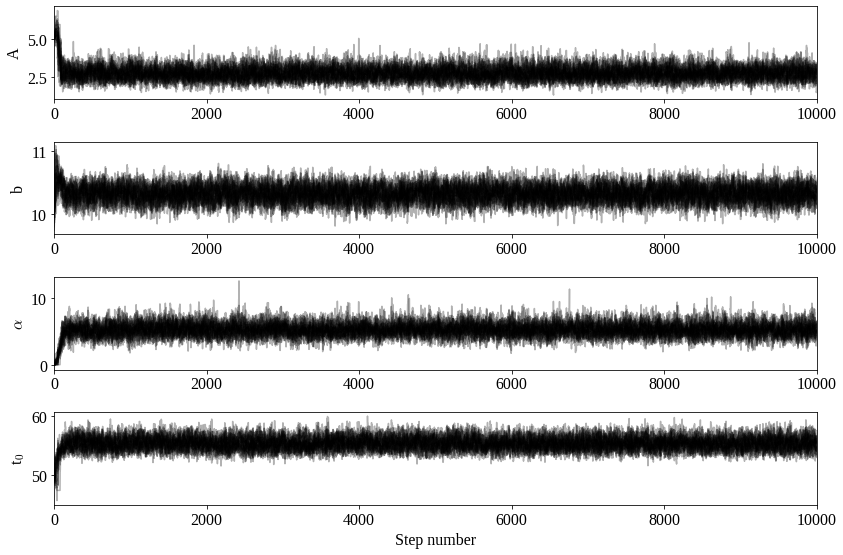

In [16]:
#get the samples
samples = chain.get_chain()

#plot the samples
labels=['A', 'b', r'$\alpha$', r't$_{0}$']
fig, ax = plt.subplots(ndim, figsize=(12, 8))
for i in range(ndim):
    ax[i].plot(samples[:, :, i], color='black', alpha=0.3)
    ax[i].set_xlim(0, nsteps)
    ax[i].set_ylabel(labels[i])
    
ax[3].set_xlabel("Step number")

In [17]:
#find the autocorrelation time to chose the burn-in and perform the thinning
tau = chain.get_autocorr_time()
print(samples.shape)
new_samples = chain.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)
np.array(new_samples.shape)

(10000, 20, 4)


array([3380,    4])

In [18]:
#print the parameters median and the 90% confidence level
median_parameters = []
low_err = []
up_err = []

for i in range(ndim):
    low, med, up = np.percentile(new_samples[:,i],[5,50, 95])
    median_parameters.append(med)
    low_err.append(med - low)
    up_err.append(up - med)
    print(labels[i], med, '+', up-med, '-', med-low)

A 2.740853033272549 + 0.6957523742937073 - 0.5815550899137518
b 10.3245023547874 + 0.19115236638402422 - 0.20527908759748037
$\alpha$ 5.25081327628453 + 1.488677199854041 - 1.3595097977758157
t$_{0}$ 55.38428066125899 + 1.71943493285535 - 1.6505236172494975


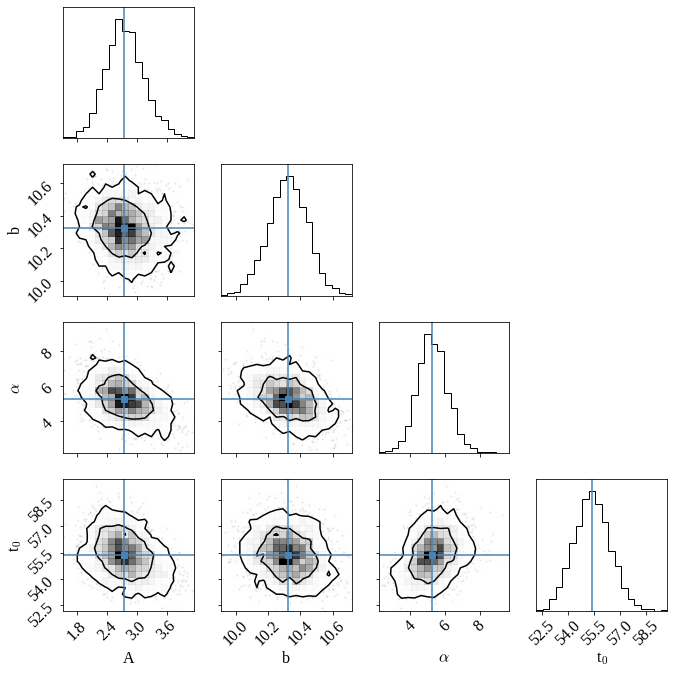

In [20]:
# Make the corner plot
figure = corner.corner(new_samples, truths = median_parameters, truths_color = 'tab:red', labels=labels, levels=[0.683,0.955]);

### Try to run an MCMC with two models (burst and gaussian) to evaluate the Odds ratio through product space method

In [21]:
def hyper_model(x, par):
    #exponential parameters
    A1, b, alpha, t01, A2, sigma, t02, n = par
    
    return np.where(n < 0, np.where(x < t01, b, b + A1*np.exp(-alpha*(x - t01))), 
                    b + A2*np.exp(-(x - t02)**2/(2*sigma**2)))

t0min,t0max = 40,60
Amin,Amax = 0,10
bmin,bmax = 5,15
alphamin,alphamax = 1e-3,1
sigmamin, sigmamax = 0,10
nmin, nmax = -1, 1

def hyper_Logprior(par):
    A1, b, alpha, t01, A2, sigma, t02, n = par

    if Amin < A1 < Amax and Amin < A2 < Amax and bmin < b < bmax and t0min < t01 < t0max and t0min < t02 < t0max and alphamin < alpha < alphamax and sigmamin < sigma < sigmamax and nmin < n < nmax:
        return -np.log(alpha)-np.log(sigma)
    else:
        return -np.inf
    
#loglikelihood
def hyper_LogLike(par):
    y = hyper_model(data[:, 0], par)
    return -0.5*np.sum((data[:, 1]-y)**2/data[:, 2]**2 )
   
#logposterior
#def hyper_Logposterior(par):
#    return hyper_LogLike(par) + hyper_Logprior(par)

#logposterior
def hyper_Logposterior(par, data, model):
    return LogLike(data, par , model) + hyper_Logprior(par)

In [22]:
#starting parameters
np.random.seed(1)
A1_0 = 5 + 0.1*np.random.randn(nwalkers)
b_0 = 10 + 0.1*np.random.randn(nwalkers)
alpha_0 = alpha_max + 0.1*np.random.randn(nwalkers)
t01_0 = 50 + 1*np.random.randn(nwalkers)
A2_0 = 5 + 0.1*np.random.randn(nwalkers)
sigma_0 = 5 + 0.1*np.random.randn(nwalkers)
t02_0 = 50 + 1*np.random.randn(nwalkers)
n_0 = +0.001*np.random.randn(nwalkers)

par_0 = np.array([A1_0, b_0, alpha_0, t01_0, A2_0, sigma_0, t02_0, n_0]).transpose()
print(par_0.shape)

(20, 8)


In [23]:
chain = emcee.EnsembleSampler(nwalkers, 8, hyper_Logposterior, args=[data, hyper_model])
chain.run_mcmc(par_0, int(1e6));

/home/irene/.local/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Text(0.5, 0, 'Step number')

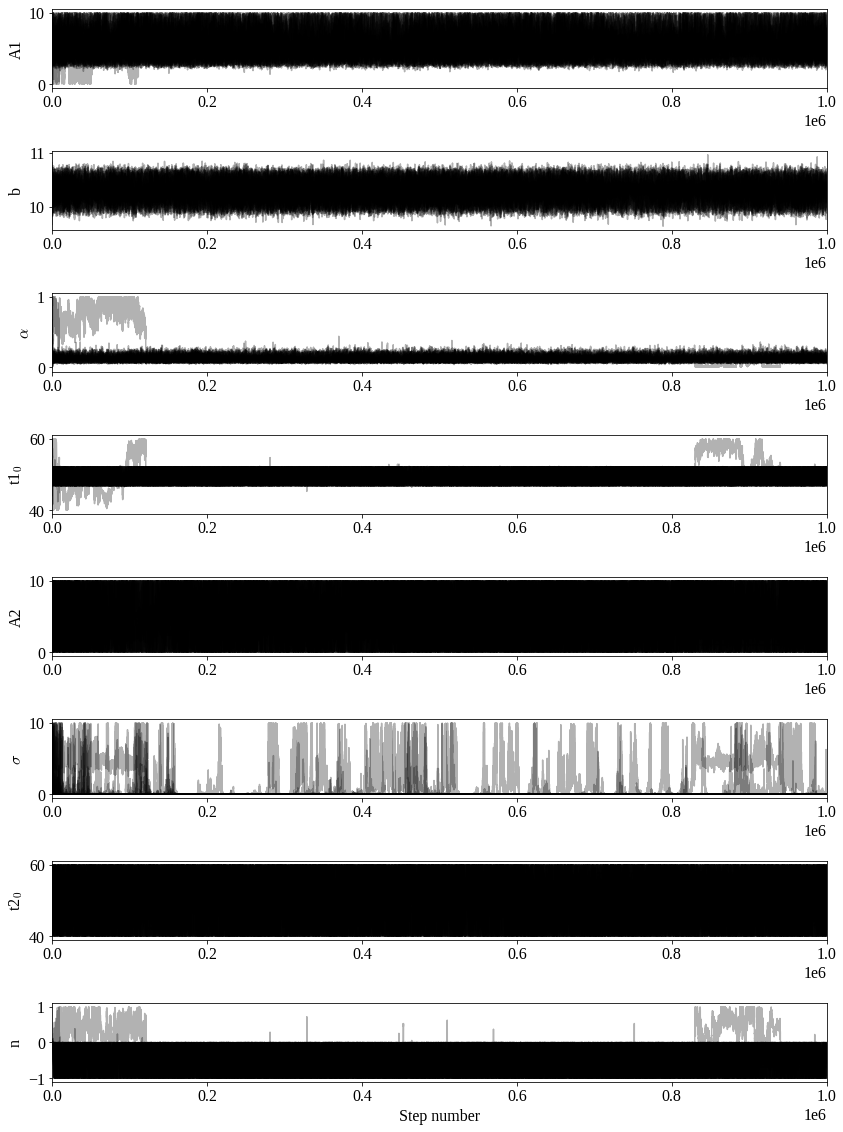

In [24]:
#get the samples
samples = chain.get_chain()

#plot the samples
labels=['A1', 'b', r'$\alpha$', r't1$_{0}$', 'A2', r'$\sigma$', r't2$_{0}$', 'n']
fig, ax = plt.subplots(8, figsize=(12, 16))
for i in range(8):
    ax[i].plot(samples[:, :, i], color='black', alpha=0.3)
    ax[i].set_xlim(0, 1e6)
    ax[i].set_ylabel(labels[i])
    
ax[-1].set_xlabel("Step number")

In [25]:
#find the autocorrelation time to chose the burn-in and perform the thinning
tau = chain.get_autocorr_time()
new_samples = chain.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)
np.array(new_samples.shape)

array([1220,    8])

In [26]:
print(f'Bayes factor of burst model vs. gaussian model: {len(new_samples[new_samples[:, -1]<0])/len(new_samples[new_samples[:, -1]>0]):.2f}')

Bayes factor of burst model vs. gaussian model: 100.67
